<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/PNSPV/notebooky/cv07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Úloha - fine-tuning

Túto úlohu vypracujte na cloude. Pripraviť si ju môžete u seba, alebo v Colabe. Skúste si ju však spustiť aj na cloude.

V tejto úlohe budeme trénovať sieť s predtrénovanými váhami tzv. fine-tuning alebo transfer learning. Predtrénované modely prevezmeme z torchvision.models na datasete cats vs. dogs, ktorý stiahnete napríklad tu:


```
https://files.fast.ai/data/examples/dogscats.tgz
```

Pre prácu s datasetom použite torchvision.datasets.ImageFolder. Keďže predtrénovaný model predpokladá že na vstupe bude normalizovaný obrázok, tak musíte v jeho konštruktore použiť aj transformácie:

```python
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])
```


Po načítaní modelu si musíme najprv urpaviť jeho výstup. To spravíme tak, že premeníme jeho parameter fc, tak aby na výstupe boli len dva neuróny (alebo jeden + sigmoid). Ak chceme zmraziť vrstvy, tak je vhodné spraviť to ešte predtým. Optimalizovať potom budeme len úplne poslednú vrstvu. Detailnejšie info napr. [pytorch tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

```python
from torchvision import models

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = torch.nn.Linear(model.fc.in_features, 2))

optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)
```

Model potom skúste natrénovať v štandardnom trénovacom loope. Nezabudnite dať pred trénovací loop model.train() a pred validačný model.eval()! Inak to nebude fungovať.



## 2. Úloha Vizualizácie

Teraz si skúsime overiť ktoré časti v obraze sú pre klasifikáciu dôležité. To spravíme tak, že si vezmeme testovací obrázok zistíme ako sieť klasifikuje. Potom do obrázka budeme vkladať na rôzne miesta čierny štvorec. Potom zistíme ako veľmi sa zmenila predpoveď modelu. Z týchto zmien potom spravíme heatmapu.

Použite predtrénovaný model a nejaký náhodný obrázok z internetu. Samozrejme bude nutné aplikovať transformácie.



Najprv si načítame nejaké testovacie obrázky. Aby sme si uľahčili prácu, tak si ich rovno zmenšíme na rozmer 224 x 224 a dáme do floatov.

In [ ]:
import cv2

test_imgs = []
!wget https://pixnio.com/free-images/2017/06/08/2017-06-08-13-53-59-900x576.jpg
test_imgs.append(cv2.resize(cv2.imread('2017-06-08-13-53-59-900x576.jpg'),(224,224)) / 255)
!wget https://storage.needpix.com/rsynced_images/diver-1881751_1280.jpg
test_imgs.append(cv2.resize(cv2.imread('diver-1881751_1280.jpg'),(224,224)) / 255)
!wget https://cdn.pixabay.com/photo/2017/09/22/23/24/white-stork-2777489_960_720.jpg
test_imgs.append(cv2.resize(cv2.imread('white-stork-2777489_960_720.jpg'),(224,224)) / 255)
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Croatia_police_van_%2804%29.JPG/800px-Croatia_police_van_%2804%29.JPG
test_imgs.append(cv2.resize(cv2.imread('800px-Croatia_police_van_(04).JPG'),(224,224)) / 255)

--2021-11-09 00:29:15--  https://pixnio.com/free-images/2017/06/08/2017-06-08-13-53-59-900x576.jpg
Resolving pixnio.com (pixnio.com)... 170.249.203.179
Connecting to pixnio.com (pixnio.com)|170.249.203.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311968 (305K) [image/jpeg]
Saving to: ‘2017-06-08-13-53-59-900x576.jpg’

2017-06-08-13-53-59 100%[===================>] 304.66K  1.95MB/s    in 0.2s    

2021-11-09 00:29:15 (1.95 MB/s) - ‘2017-06-08-13-53-59-900x576.jpg’ saved [311968/311968]

--2021-11-09 00:29:15--  https://storage.needpix.com/rsynced_images/diver-1881751_1280.jpg
Resolving storage.needpix.com (storage.needpix.com)... 89.40.7.139
Connecting to storage.needpix.com (storage.needpix.com)|89.40.7.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 282433 (276K) [application/octet-stream]
Saving to: ‘diver-1881751_1280.jpg’

diver-1881751_1280. 100%[===================>] 275.81K   365KB/s    in 0.8s    

2021-11-09 00:29

Obrázky si zobrazíme.

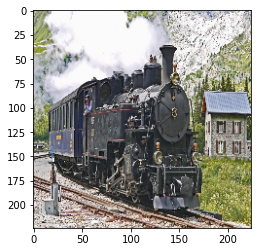

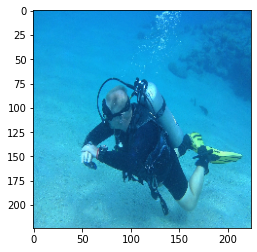

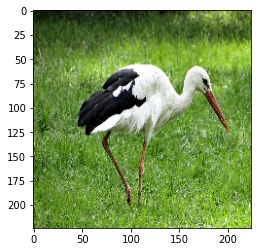

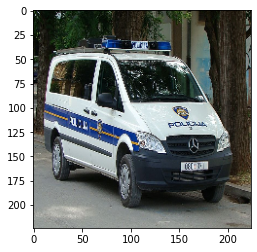

In [ ]:
from matplotlib import pyplot as plt
for img in test_imgs:
  plt.imshow(img[:, :, ::-1])
  plt.show()

In [ ]:
import torch
from torchvision import models, transforms

import numpy as np

Ak chceme obrázok aplikovať na sieť, tak ešte potrebujeme prehodiť kanál dopredu a aplikovať normalizáciu. Môžeme si overiť, že sieť funguje dobre ak si pozrieme [tabuľku tried v imagenete](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

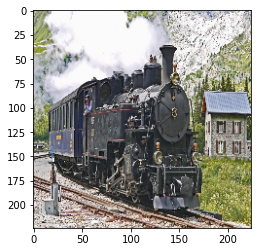

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor(820, device='cuda:0')
tensor(20.1255, device='cuda:0', grad_fn=<MaxBackward1>)


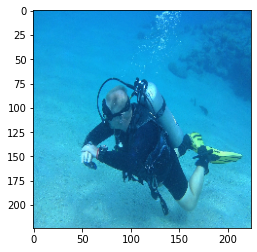

tensor(983, device='cuda:0')
tensor(16.3911, device='cuda:0', grad_fn=<MaxBackward1>)


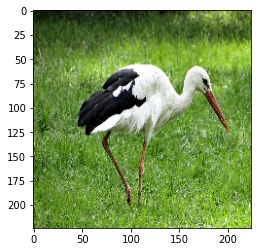

tensor(127, device='cuda:0')
tensor(19.8845, device='cuda:0', grad_fn=<MaxBackward1>)


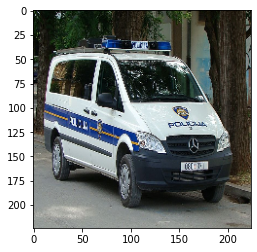

tensor(734, device='cuda:0')
tensor(23.7845, device='cuda:0', grad_fn=<MaxBackward1>)


In [ ]:
from torchvision.transforms.functional import normalize

model = models.resnet18(pretrained=True).eval().cuda()


def prepare_for_model(img):
  img = np.transpose(img[:, :, ::-1], (2, 0, 1))[np.newaxis, ...].astype(np.float32)
  img_torch = torch.from_numpy(img)
  img_torch = normalize(img_torch, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  return img_torch


for img in test_imgs:
  plt.imshow(img[:, :, ::-1])  
  plt.show()
  out = model(prepare_for_model(img).cuda())
  print(torch.argmax(out))
  print(torch.max(out))


Túto funkciu napíšte tak aby vrátila heatmapu veľkosti $rectangle\_num \times rectangle\_num$. Jednotlivé elementy heatmapy budú reprezentovať to ako veľmi sa zmení predikcia pre pôvodnú triedu obrázku ak na korešpondujúce miesto v obrázku pridáme čierny štvorec veľkosti $rectangle\_size \times rectangle\_size$. Použite napr. cv2.rectangle.

Na začiatku samozrejme musíte zistiť, ktorá trieda je predikovaná pre pôvodný obrázok. Potom sa vždy na výstupe budeme pozerať na hodnotu na danom indexe. Čim viac sa zníži tým väčšiu hodnotu dáme do heatmapy. Tým pádom nám heatmapa ukáža ktoré časti sú pre sieť najdôležitejšie.

Pri implementácii skúste využiť to, že model dokáže spracovať viacero obrázkov naraz ak ich poukladáte "na seba" podobne ako pri generovaní batchu. 

In [ ]:
def generate_heatmap(img, model, rectangle_num, rectangle_size):
  heatmap = np.zeros([rectangle_num, rectangle_num])
  
  # doplnte kod
  
  return heatmap

Tento kód by mal vygenerovať heatmapy pre testovacie obrázky.

tensor(820, device='cuda:0')


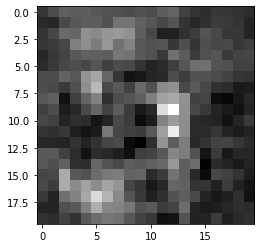

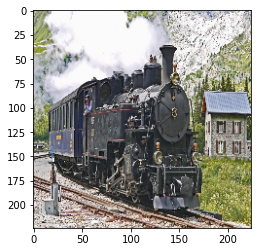

tensor(983, device='cuda:0')


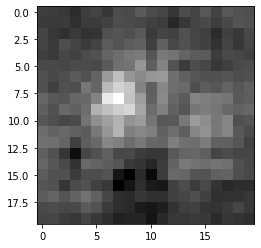

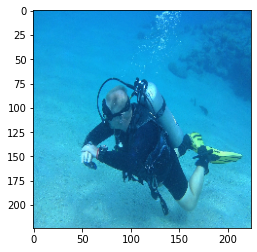

tensor(127, device='cuda:0')


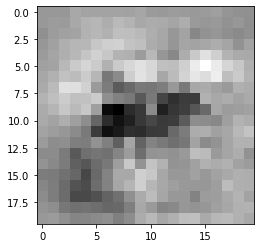

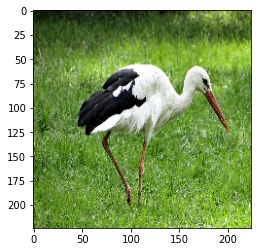

tensor(734, device='cuda:0')


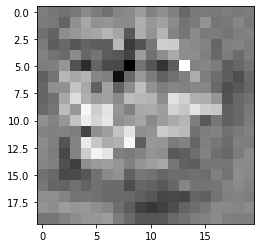

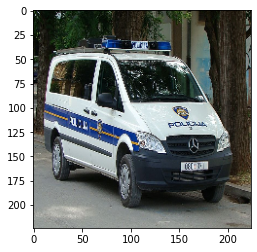

In [ ]:
for test_img in test_imgs:
  hmap = generate_heatmap(test_img, model, 20, 9)
  plt.imshow(hmap,cmap='gray')
  plt.show()
  plt.imshow(test_img[:,:,::-1])
  plt.show()